<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>






<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/code_and_data/blob/main/Mining_GeoDFs.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Mining your GeoDataFrame

This final session will need all the files from the zipped folder "miningGDF" available [here](https://drive.google.com/drive/folders/1aLZXirKg0AeEeY7CRpYCOjVgYv2Dj2Hx?usp=sharing). Download and unzip that folder, which has two folders (map and data).

First, let's open the _brazilMaps_5641.gpkg_ map file:

In [1]:
#en la evaluacion solo poner lo que se les pide
from  fiona import listlayers
import os

brazilMaps=os.path.join('maps','brazilMaps_5641.gpkg')

#layers in maps
listlayers(brazilMaps)

['border',
 'airports',
 'country',
 'cities',
 'rivers',
 'states',
 'municipalities']

In [2]:
# reading in the data:
import os
import geopandas as gpd

states=gpd.read_file(brazilMaps,layer='states')
municipalities=gpd.read_file(brazilMaps,layer='municipalities')
airports=gpd.read_file(brazilMaps,layer='airports')
rivers=gpd.read_file(brazilMaps,layer='rivers')
border=gpd.read_file(brazilMaps,layer='border')

Now, we are going to add more data. In this [link](https://msi.nga.mil/Publications/WPI) we find the  World Port Index (Pub 150), which contains several data on major ports and terminals world-wide. Read in the **UpdatedPub150.csv** file also from zipped folder:

In [3]:
import pandas as pd 


portsFile=os.path.join('data','UpdatedPub150.csv')

infoseaports=pd.read_csv(portsFile)
#columns available (so many)
infoseaports.columns.to_list()

['World Port Index Number',
 'Region Name',
 'Main Port Name',
 'Alternate Port Name',
 'UN/LOCODE',
 'Country Code',
 'World Water Body',
 'IHO S-130 Sea Area',
 'Sailing Direction or Publication',
 'Publication Link',
 'Standard Nautical Chart',
 'IHO S-57 Electronic Navigational Chart',
 'IHO S-101 Electronic Navigational Chart',
 'Digital Nautical Chart',
 'Tidal Range (m)',
 'Entrance Width (m)',
 'Channel Depth (m)',
 'Anchorage Depth (m)',
 'Cargo Pier Depth (m)',
 'Oil Terminal Depth (m)',
 'Liquified Natural Gas Terminal Depth (m)',
 'Maximum Vessel Length (m)',
 'Maximum Vessel Beam (m)',
 'Maximum Vessel Draft (m)',
 'Offshore Maximum Vessel Length (m)',
 'Offshore Maximum Vessel Beam (m)',
 'Offshore Maximum Vessel Draft (m)',
 'Harbor Size',
 'Harbor Type',
 'Harbor Use',
 'Shelter Afforded',
 'Entrance Restriction - Tide',
 'Entrance Restriction - Heavy Swell',
 'Entrance Restriction - Ice',
 'Entrance Restriction - Other',
 'Overhead Limits',
 'Underkeel Clearance Manage

Let's do some preprocessing:

In [4]:
#duda
#rename
infoseaports.rename(columns={'Main Port Name':'portName'},inplace=True)
#subset
infoseaports=infoseaports.loc[:,['portName', 'Country Code','Latitude', 'Longitude']]

# we have now
infoseaports.info()
#crs no proyectado 4326

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3739 entries, 0 to 3738
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portName      3739 non-null   object 
 1   Country Code  3739 non-null   object 
 2   Latitude      3739 non-null   float64
 3   Longitude     3739 non-null   float64
dtypes: float64(2), object(2)
memory usage: 117.0+ KB


In [5]:
# some rows
infoseaports.head()

portName   Country Code   Latitude   Longitude
0                 Maurer  United States  40.533333  -74.250000
1  Mangkasa Oil Terminal      Indonesia  -2.733333  121.066667
2                Iharana     Madagascar -13.350000   50.000000
3                Andoany     Madagascar -13.400000   48.300000
4            Chake Chake       Tanzania  -5.250000   39.766667

It looks ready to become a spatial object (GDF of points):

In [6]:
#spatial points (unprojected)
seaports=gpd.GeoDataFrame(data=infoseaports.copy(),
                           geometry=gpd.points_from_xy(infoseaports.Longitude,
                                                       infoseaports.Latitude), 
                          crs=4326)# notice it is unprojected

# subset:
seaports_bra=seaports[seaports['Country Code']=='Brazil'].copy()

# reset indexes
seaports_bra.reset_index(drop=True, inplace=True)

# reprojecting
seaports_bra_5641=seaports_bra.to_crs(5641) # projected crs

Let me plot seaports along with the airports (only large ones) we have:

<Axes: >

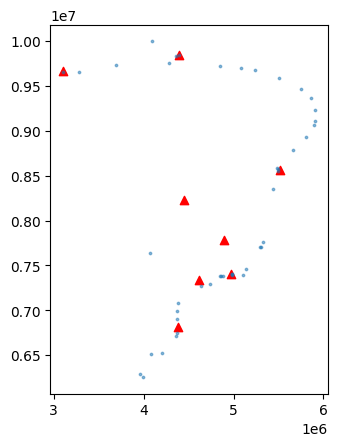

In [8]:
# subsetting
largeAirports=airports[airports['type']=='large_airport'] #can't use "airports.type"
largeAirports.reset_index(drop=True, inplace=True)

#plotting
base=largeAirports.plot(color='red',marker="^")
seaports_bra_5641.plot(ax=base,alpha=0.5,markersize=3)

# Part I. Distance between spatial objects

## Distance between points

The easiest way to understand distance is to compute how far two coordinates are from each other.

You have the seaports:

In [9]:
seaports_bra_5641.head()

portName Country Code   Latitude  Longitude  \
0  Dtse / Gegua Oil Terminal       Brazil -22.816667 -43.150000   
1          Porto De Mucuripe       Brazil  -3.716667 -38.483333   
2                   Portocel       Brazil -19.850000 -40.050000   
3                Santa Clara       Brazil -20.883333 -51.366667   
4                      Aratu       Brazil -12.783333 -38.500000   

                          geometry  
0  POINT (4983312.180 7408269.607)  
1  POINT (5502488.831 9588988.711)  
2  POINT (5328193.788 7760588.183)  
3  POINT (4069190.463 7638681.573)  
4  POINT (5500634.592 8575321.802)

..and the large airports:

In [10]:
largeAirports.head()

name           type  \
0  Guarulhos - Governador André Franco Montoro In...  large_airport   
1       Rio Galeão – Tom Jobim International Airport  large_airport   
2  Presidente Juscelino Kubitschek International ...  large_airport   
3  Deputado Luiz Eduardo Magalhães International ...  large_airport   
4               Tancredo Neves International Airport  large_airport   

   latitude_deg  longitude_deg  elevation_ft       region_name  \
0    -23.431944     -46.467778        2461.0         São Paulo   
1    -22.809999     -43.250557          28.0    Rio de Janeiro   
2    -15.869167     -47.920834        3497.0  Distrito Federal   
3    -12.908611     -38.322498          64.0             Bahia   
4    -19.635710     -43.966928        2721.0      Minas Gerais   

     municipality                         geometry  
0       São Paulo  POINT (4614202.306 7334259.930)  
1  Rio De Janeiro  POINT (4972125.000 7409069.810)  
2        Brasília  POINT (4452546.729 8223176.558)  
3        Salvador  POINT (5520382.068 8561117.560)  
4  Belo Horizonte  POINT (4892427.199 7785766.984)

If both GDFs have the same projected CRS, we can use the **distance** function. In this case, just two selected points:

In [11]:
# distance between 'Guarulhos' and 'Dtse / Gegua Oil Terminal' in km
largeAirports.iloc[0].geometry.distance(seaports_bra_5641.iloc[0].geometry)/1000
#geometry para saber la distancia de un punto a otro punto. la distancia sale en km

376.45654676312876

What about computing all possible distances between those GDFs?

In [12]:
#try 1: default
seaports_bra_5641.geometry.apply\
(lambda g: largeAirports.geometry.distance(g)/1000)
#a la columna geometrya aeropuestos la calcula toda entre mil

0            1            2            3            4  \
0    376.456547    11.215763   972.514937  1271.810704   388.283851   
1   2423.397372  2243.508905  1722.736560  1028.026882  1903.623858   
2    831.588609   500.350026   990.326096   823.276150   436.493404   
3    624.267928   931.671799   698.996719  1719.547971   836.273186   
4   1525.121886  1280.416377  1105.664706    24.325363   996.650914   
5   2293.987340  2046.008923  1769.194495   771.805485  1764.410446   
6    639.170185   897.615004  1481.745011  2151.084932  1165.831878   
7    244.481056   121.176128   929.825791  1352.673407   403.398003   
8   2382.062554  2146.510809  1815.145260   870.955869  1851.717042   
9   2410.208878  2193.956793  1791.587591   928.562523  1881.204203   
10  2393.450212  2310.537281  1544.561643  1336.611633  1931.013388   
11  2766.093800  2918.388264  1963.898015  2649.252784  2583.976539   
12  2673.510009  2808.714761  1847.405547  2490.695104  2465.358981   
13  2515.667230  2499.852237  1617.854012  1707.900996  2114.986138   
14   538.426111   173.420064  1023.657258  1163.818841   405.739799   
15   378.616408    17.302181   981.245269  1277.516480   396.935864   
16  1231.514690  1507.888377  1994.680043  2754.692102  1761.854340   
17   372.791427    14.276947   979.910654  1281.664354   397.597371   
18  2193.153788  1937.633094  1700.323476   668.041173  1664.874772   
19   908.839653  1171.810543  1718.844210  2425.767733  1437.920935   
20  1520.705932  1278.570240  1094.591652    37.341910   991.803155   
21   675.125220   931.277503  1516.000405  2186.377025  1201.636212   
22  1790.474921  1540.209929  1334.020743   265.870906  1262.124954   
23  2711.450483  2731.884301  1808.103095  2025.262379  2350.094092   
24  1990.401822  1732.707887  1527.486685   465.341625  1463.059066   
25  1507.164150  1260.734281  1097.452341    22.583078   979.114274   
26  1246.983250  1515.704608  2021.859766  2767.960686  1777.189351   
27  2568.164421  2650.892609  1688.418700  2167.842678  2285.043521   
28   498.351752   138.555859  1060.757532  1240.894747   451.113652   
29  1309.247717  1050.147361   998.397741   227.003707   786.776785   
30   489.507027   780.730917  1317.417812  2012.004016  1019.673197   
31  2440.461226  2443.236436  1538.183094  1721.297005  2059.664194   
32   254.627362   111.280352   938.275198  1350.724987   406.474580   
33  2427.461207  2286.191573  1655.985765  1152.632398  1925.446175   
34  2403.552114  2285.762978  1597.397618  1213.978580  1915.710093   
35  2155.051844  1898.040763  1670.722748   629.817598  1627.150216   
36   126.832365   267.214083   974.578264  1495.383628   520.941997   
37   975.294855  1259.726170  1746.835084  2499.406733  1505.554885   
38   419.666706   730.548681  1235.085432  1944.801215   949.602641   
39    65.309716   366.023007   968.438000  1565.357792   575.901215   
40   776.971920   439.638859   990.149828   884.248413   412.110662   
41  2507.321205  2495.777040  1608.163719  1718.294452  2111.090564   
42   786.994711   449.146894   996.032706   878.136233   420.478463   
43   339.344105   670.555330  1142.230423  1863.182040   866.180509   
44   275.412013    90.553384   943.847471  1337.414605   401.585110   

              5            6            7  
0   2936.568258   845.014311  2510.234598  
1   2400.478414  2992.287458  1141.403441  
2   2928.112036  1337.994526  2287.848785  
3   2243.945536   881.830905  2232.167407  
4   2633.078121  2086.128729  1688.319476  
5   2839.030154  2855.954845  1639.305541  
6   3183.058035    71.677342  3103.880291  
7   2874.224071   739.537460  2506.404649  
8   2781.274261  2947.244055  1555.463073  
9   2651.803098  2978.427871  1410.340738  
10  1745.552254  2939.095440   475.674348  
11    11.108573  3112.575413  1298.474353  
12   178.396701  3043.589456  1126.755711  
13  1296.885238  3025.452935     8.253587  
14  2997.579611   994.830066  2499.445409  
15  2945.090706   842.067816  2518.886936  

In [13]:
# try 2: see names (change indexes)

seaports_bra_5641.set_index('portName').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000)
#aqui se ordena con nombre de puertos

name                       Guarulhos - Governador André Franco Montoro International Airport  \
portName                                                                                       
Dtse / Gegua Oil Terminal                                         376.456547                   
Porto De Mucuripe                                                2423.397372                   
Portocel                                                          831.588609                   
Santa Clara                                                       624.267928                   
Aratu                                                            1525.121886                   
Cabedelo                                                         2293.987340                   
Imbituba                                                          639.170185                   
Angra Dos Reis                                                    244.481056                   
Natal                                                            2382.062554                   
Guamare Oil Terminal                                             2410.208878                   
Itaqui                                                           2393.450212                   
Manaus                                                           2766.093800                   
Itacoatiara                                                      2673.510009                   
Belem                                                            2515.667230                   
Macae                                                             538.426111                   
Niteroi                                                           378.616408                   
Pelotas                                                          1231.514690                   
Rio De Janeiro                                                    372.791427                   
Recife                                                           2193.153788                   
Tramandai                                                         908.839653                   
Madre De Deus                                                    1520.705932                   
Laguna                                                            675.125220                   
Port De Aracaju                                                  1790.474921                   
Porto Santana                                                    2711.450483                   
Porto De Maceio                                                  1990.401822                   
Port De Salvador                                                 1507.164150                   
Rio Grande                                                       1246.983250                   
Santarem                                                         2568.164421                   
Porto Do Forno                                                    498.351752                   
Port Of Ilheus                                                   1309.247717                   
Itajai                                                            489.507027                   
Cameta                                                           2440.461226                   
Gebig                                                             254.627362                   
Camocim                                                          2427.461207                   
Tutoia                                                           2403.552114                   
Porto De Suape                                                   2155.051844                   
Sao Sebastiao                                                     126.832365                   
Porto Alegre                                                      975.294855                   
Sao Francisco                                                     419.666706                   
Santos                                                          

In [14]:
#try 3: reorder previous output

seaports_bra_5641.set_index('portName').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)
#aqui se ordena alfabeticamente
#si pide calcular distancias esta opcion sera la mejor
#lo que quiere el profesor es que se entienda lo que pide 
#solo se muestra sin guardar

name                       Deputado Luiz Eduardo Magalhães International Airport  \
portName                                                                           
Angra Dos Reis                                                   1352.673407       
Aratu                                                              24.325363       
Belem                                                            1707.900996       
Cabedelo                                                          771.805485       
Cameta                                                           1721.297005       
Camocim                                                          1152.632398       
Dtse / Gegua Oil Terminal                                        1271.810704       
Gebig                                                            1350.724987       
Guaiba Island Terminal                                           1337.414605       
Guamare Oil Terminal                                              928.562523       
Imbituba                                                         2151.084932       
Itacoatiara                                                      2490.695104       
Itajai                                                           2012.004016       
Itaqui                                                           1336.611633       
Laguna                                                           2186.377025       
Macae                                                            1163.818841       
Madre De Deus                                                      37.341910       
Manaus                                                           2649.252784       
Natal                                                             870.955869       
Niteroi                                                          1277.516480       
Paranagua                                                        1863.182040       
Pelotas                                                          2754.692102       
Port De Aracaju                                                   265.870906       
Port De Salvador                                                   22.583078       
Port Of Ilheus                                                    227.003707       
Porto Alegre                                                     2499.406733       
Porto De Maceio                                                   465.341625       
Porto De Mucuripe                                                1028.026882       
Porto De Suape                                                    629.817598       
Porto Do Forno                                                   1240.894747       
Porto Santana                                                    2025.262379       
Portocel                                                          823.276150       
Recife                                                            668.041173       
Rio De Janeiro                                                   1281.664354       
Rio Grande                                                       2767.960686       
Santa Clara                                                      1719.547971       
Santarem                                                         2167.842678       
Santos                                                           1565.357792       
Sao Francisco                                                    1944.801215       
Sao Sebastiao                                                    1495.383628       
Tramandai                                                        2425.767733       
Tubarao                                                           878.136233       
Tutoia                                                           1213.978580       
Vila Do Conde                                                    1718.294452       
Vitoria                                                           884.248413       

name                       Eduardo Gomes Internatio

Let's keep the last one:

In [15]:
distanceMatrixKM_sea_air= seaports_bra_5641.set_index('portName').geometry.apply\
                          (lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
                          sort_index(axis=0).sort_index(axis=1)
#aqui se guarda el resultado

This a data frame (pandas), and the names of the facilities are row and column indexes. This is useful this way:

In [16]:
# the mean distance from a seaport to all the large airports (sorted)
distanceMatrixKM_sea_air.mean(axis=1).sort_values(ascending=True) #axis=0?
#aqui se ve la distancia media, distancia promedio por cada fila

portName
Angra Dos Reis               1146.465071
Gebig                        1150.200738
Guaiba Island Terminal       1151.845981
Dtse / Gegua Oil Terminal    1164.012371
Rio De Janeiro               1168.190272
Niteroi                      1169.707707
Sao Sebastiao                1179.519797
Santos                       1186.176495
Macae                        1224.614645
Porto Do Forno               1238.729569
Vitoria                      1255.779907
Tubarao                      1260.952624
Portocel                     1266.998704
Santa Clara                  1271.087681
Port Of Ilheus               1344.159144
Paranagua                    1349.660596
Sao Francisco                1409.128772
Port De Salvador             1409.693480
Madre De Deus                1412.758466
Aratu                        1417.463196
Itajai                       1460.946843
Imbituba                     1586.757835
Port De Aracaju              1613.078902
Laguna                       1620.490194
Porto D

Let's compute more stats:

In [17]:
SomeStats=pd.DataFrame()
SomeStats['mean']=distanceMatrixKM_sea_air.mean(axis=1)
SomeStats['min']=distanceMatrixKM_sea_air.min(axis=1)
SomeStats['max']=distanceMatrixKM_sea_air.max(axis=1)

# see some
SomeStats.head(10)
#aqui se calcula la minima y la maxima ademas de la media

mean         min          max
portName                                                       
Angra Dos Reis             1146.465071  121.176128  2874.224071
Aratu                      1417.463196   24.325363  2633.078121
Belem                      1848.356547    8.253587  3025.452935
Cabedelo                   1997.462154  771.805485  2855.954845
Cameta                     1808.472039  149.134547  2938.884991
Camocim                    1930.427202  866.757782  2991.025682
Dtse / Gegua Oil Terminal  1164.012371   11.215763  2936.568258
Gebig                      1150.200738  111.280352  2884.184234
Guaiba Island Terminal     1151.845981   90.553384  2893.527941
Guamare Oil Terminal       2030.761462  928.562523  2978.427871

We can also use **idxmax** to get the particular locations:

In [18]:
# farthest airport to each seaport
distanceMatrixKM_sea_air.idxmax(axis=1)
#la funcion idxmax te da el maximo 
#busca elk valor maximo y devuelve la cabecera

portName
Angra Dos Reis                             Eduardo Gomes International Airport
Aratu                                      Eduardo Gomes International Airport
Belem                                       Hercílio Luz International Airport
Cabedelo                                    Hercílio Luz International Airport
Cameta                                      Hercílio Luz International Airport
Camocim                                     Hercílio Luz International Airport
Dtse / Gegua Oil Terminal                  Eduardo Gomes International Airport
Gebig                                      Eduardo Gomes International Airport
Guaiba Island Terminal                     Eduardo Gomes International Airport
Guamare Oil Terminal                        Hercílio Luz International Airport
Imbituba                                   Eduardo Gomes International Airport
Itacoatiara                                 Hercílio Luz International Airport
Itajai                                     

In [19]:
# farthest seaport to each airport
distanceMatrixKM_sea_air.idxmax(axis=0)

name
Deputado Luiz Eduardo Magalhães International Airport                   Rio Grande
Eduardo Gomes International Airport                                     Rio Grande
Guarulhos - Governador André Franco Montoro International Airport           Manaus
Hercílio Luz International Airport                                   Porto Santana
Presidente Juscelino Kubitschek International Airport                   Rio Grande
Rio Galeão – Tom Jobim International Airport                                Manaus
Tancredo Neves International Airport                                        Manaus
Val de Cans/Júlio Cezar Ribeiro International Airport                   Rio Grande
dtype: object

In [20]:
# closest airport to each seaport
distanceMatrixKM_sea_air.idxmin(axis=1)

portName
Angra Dos Reis                    Rio Galeão – Tom Jobim International Airport
Aratu                        Deputado Luiz Eduardo Magalhães International ...
Belem                        Val de Cans/Júlio Cezar Ribeiro International ...
Cabedelo                     Deputado Luiz Eduardo Magalhães International ...
Cameta                       Val de Cans/Júlio Cezar Ribeiro International ...
Camocim                      Val de Cans/Júlio Cezar Ribeiro International ...
Dtse / Gegua Oil Terminal         Rio Galeão – Tom Jobim International Airport
Gebig                             Rio Galeão – Tom Jobim International Airport
Guaiba Island Terminal            Rio Galeão – Tom Jobim International Airport
Guamare Oil Terminal         Deputado Luiz Eduardo Magalhães International ...
Imbituba                                    Hercílio Luz International Airport
Itacoatiara                                Eduardo Gomes International Airport
Itajai                                     

In [21]:
# closest seaport to each airport
distanceMatrixKM_sea_air.idxmin(axis=0)

name
Deputado Luiz Eduardo Magalhães International Airport                         Port De Salvador
Eduardo Gomes International Airport                                                     Manaus
Guarulhos - Governador André Franco Montoro International Airport                       Santos
Hercílio Luz International Airport                                                    Imbituba
Presidente Juscelino Kubitschek International Airport                              Santa Clara
Rio Galeão – Tom Jobim International Airport                         Dtse / Gegua Oil Terminal
Tancredo Neves International Airport                                 Dtse / Gegua Oil Terminal
Val de Cans/Júlio Cezar Ribeiro International Airport                                    Belem
dtype: object

### Exercises Part I

<div class="alert-warning">
    
Exercises 1,2,3,4 for this part must read you data from GitHub links, and the coding and results must be published using GitHub Pages

</div>

### Exercise 1

<div class="alert-success">
    
1. Use two maps of points.

2. Compute the distance matrix for both maps.

3. Select one row of the distance matrix, and plot the two points with the minimal distance on top of the country of your choosing.
</div>

In [ ]:
#hacer en un repo aparte. los areopuertos y nuestro mapa
#calcular las distancia
#graficar los puntos de esas distancias

## Distance between line and point

Let's take a look at the rivers we have:

In [ ]:
#distancia entre una linea y un punto

In [22]:
rivers

NAME  SYSTEM  \
0                      Parana  Parana   
1   Rio Grande, South America  Parana   
2                    Paraguay  Parana   
3               Rio Paranaiba  Parana   
4               San Francisco    None   
5                    Araguaia    None   
6             Rio Teles Pires  Amazon   
7                   Tocantins    None   
8                       Xingu  Amazon   
9                     Tapajos  Amazon   
10                    Guapore  Amazon   
11                Rio Juruena  Amazon   
12              Madre de Dios  Amazon   
13                    Madeira  Amazon   
14                      Purus  Amazon   
15                   Putamayo  Amazon   
16                     Amazon  Amazon   
17                     Japura  Amazon   
18                  Rio Negro  Amazon   
19                 Rio Branco  Amazon   
20                    Orinoco    None   

                                             geometry  
0   LINESTRING (3732042.591 7071745.007, 3731126.2...  
1   LINESTRING (4847414.941 7485403.427, 4904215.7...  
2   LINESTRING (3835020.714 8129825.454, 3741785.7...  
3   LINESTRING (4663725.681 7856927.247, 4651734.8...  
4   LINESTRING (4641228.597 7720217.791, 4694598.5...  
5   LINESTRING (3905017.583 7982502.448, 3886630.3...  
6   LINESTRING (3662673.786 8372171.932, 3703620.0...  
7   MULTILINESTRING ((4387427.882 9414376.665, 433...  
8   MULTILINESTRING ((3695122.042 8316613.866, 381...  
9   LINESTRING (3732370.184 9738566.318, 3684430.3...  
10  MULTILINESTRING ((2541060.695 8858215.442, 253...  
11  LINESTRING (3247949.959 8371569.076, 3326166.4...  
12  LINESTRING (2503339.825 8833877.537, 2541060.6...  
13  LINESTRING (2541060.695 8858215.442, 2543056.1...  
14  LINESTRING (1930284.577 8924552.433, 1988297.8...  
15  LINESTRING (2030904.206 9687127.562, 2069913.7...  
16  MULTILINESTRING ((2966611.642 9601126.236, 303...  
17  MULTILINESTRING ((2558466.758 9753208.309, 259...  
18  MULTILINESTRING ((2369238.698 10113778.427, 23...  
19  LINESTRING (3128359.276 10391682.551, 3087561....  
20  LINESTRING (2736000.809 10261703.015, 2757112....

In [23]:
#keep one:

rivers[rivers.NAME.str.contains('Grande')]

NAME  SYSTEM  \
1  Rio Grande, South America  Parana   

                                            geometry  
1  LINESTRING (4847414.941 7485403.427, 4904215.7...

You can see that distance works between these two elements:

In [24]:
# distance from each airport to Rio Grande , trata de encontrar la distancia mas corta
rivers[rivers.NAME.str.contains('Grande')].iloc[0].geometry.distance(largeAirports.set_index('name').geometry)/1000

name
Guarulhos - Governador André Franco Montoro International Airport     277.907341
Rio Galeão – Tom Jobim International Airport                          142.788995
Presidente Juscelino Kubitschek International Airport                 474.182743
Deputado Luiz Eduardo Magalhães International Airport                1169.515892
Tancredo Neves International Airport                                  186.261705
Eduardo Gomes International Airport                                  2179.073568
Hercílio Luz International Airport                                    816.540197
Val de Cans/Júlio Cezar Ribeiro International Airport                2080.773488
Name: geometry, dtype: float64

Based on what we did previously, let's compute all the distances:

In [25]:
distanceMatrixKM_riv_air=rivers.set_index('NAME').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)
distanceMatrixKM_riv_air
#ya no es un punto ahora es una linea

name                       Deputado Luiz Eduardo Magalhães International Airport  \
NAME                                                                               
Amazon                                                           1978.845762       
Araguaia                                                         1308.019242       
Guapore                                                          2458.024484       
Japura                                                           3117.822502       
Madeira                                                          2490.080873       
Madre de Dios                                                    2994.098026       
Orinoco                                                          3249.139817       
Paraguay                                                         1739.671168       
Parana                                                           1611.687580       
Purus                                                            2736.905571       
Putamayo                                                         3451.573354       
Rio Branco                                                       2903.473138       
Rio Grande, South America                                        1169.515892       
Rio Juruena                                                      2194.275300       
Rio Negro                                                        2619.414491       
Rio Paranaiba                                                    1091.253494       
Rio Teles Pires                                                  1823.107459       
San Francisco                                                     370.579153       
Tapajos                                                          2140.881144       
Tocantins                                                        1064.930616       
Xingu                                                            1557.130671       

name                       Eduardo Gomes International Airport  \
NAME                                                             
Amazon                                               25.427785   
Araguaia                                           1300.153160   
Guapore                                             982.524731   
Japura                                              503.372843   
Madeira                                             152.897925   
Madre de Dios                                       982.524731   
Orinoco                                             698.056740   
Paraguay                                           1600.729478   
Parana                                             2181.114140   
Purus                                               150.263432   
Putamayo                                            854.123150   
Rio Branco                                          263.496551   
Rio Grande, South America                          2179.073568   
Rio Juruena                                         526.221195   
Rio Negro                                             4.372137   
Rio Paranaiba                                      2078.248955   
Rio Teles Pires                                     526.221195   
San Francisco                                      2104.310283   
Tapajos                                             432.446561   
Tocantins                                          1176.263530   
Xingu                                               842.864305   

name                       Guarulhos - Governador André Franco Montoro International Airport  \
NAME                                                                                           
Amazon                                                           2548.243958                   
Araguaia                                                          960.812850                   
Guapore                                                          1984.059015                   
Japura                                                           307

Here, we see one row (river), that tells the distance to each column (large airport):

In [26]:
distanceMatrixKM_riv_air.loc['Rio Grande, South America'].sort_values()
#como he seleccionado rio grande, esta es la distancia a todos los aeropuertos

name
Rio Galeão – Tom Jobim International Airport                          142.788995
Tancredo Neves International Airport                                  186.261705
Guarulhos - Governador André Franco Montoro International Airport     277.907341
Presidente Juscelino Kubitschek International Airport                 474.182743
Hercílio Luz International Airport                                    816.540197
Deputado Luiz Eduardo Magalhães International Airport                1169.515892
Val de Cans/Júlio Cezar Ribeiro International Airport                2080.773488
Eduardo Gomes International Airport                                  2179.073568
Name: Rio Grande, South America, dtype: float64

Let's try a simple plot of the river and the airports:

In [27]:
base=largeAirports.explore(color='red',marker_kwds=dict(radius=10))
rivers[rivers.NAME.str.contains('Grande')].explore(m=base)
#aqui esta el rio grande y los aeropuertos, lo de hace rato son las distancias de los aeropuertos al rio

Now, let's focus on the rivers that belong to a system:

In [28]:
rivers[~rivers.SYSTEM.isna()]

NAME  SYSTEM  \
0                      Parana  Parana   
1   Rio Grande, South America  Parana   
2                    Paraguay  Parana   
3               Rio Paranaiba  Parana   
6             Rio Teles Pires  Amazon   
8                       Xingu  Amazon   
9                     Tapajos  Amazon   
10                    Guapore  Amazon   
11                Rio Juruena  Amazon   
12              Madre de Dios  Amazon   
13                    Madeira  Amazon   
14                      Purus  Amazon   
15                   Putamayo  Amazon   
16                     Amazon  Amazon   
17                     Japura  Amazon   
18                  Rio Negro  Amazon   
19                 Rio Branco  Amazon   

                                             geometry  
0   LINESTRING (3732042.591 7071745.007, 3731126.2...  
1   LINESTRING (4847414.941 7485403.427, 4904215.7...  
2   LINESTRING (3835020.714 8129825.454, 3741785.7...  
3   LINESTRING (4663725.681 7856927.247, 4651734.8...  
6   LINESTRING (3662673.786 8372171.932, 3703620.0...  
8   MULTILINESTRING ((3695122.042 8316613.866, 381...  
9   LINESTRING (3732370.184 9738566.318, 3684430.3...  
10  MULTILINESTRING ((2541060.695 8858215.442, 253...  
11  LINESTRING (3247949.959 8371569.076, 3326166.4...  
12  LINESTRING (2503339.825 8833877.537, 2541060.6...  
13  LINESTRING (2541060.695 8858215.442, 2543056.1...  
14  LINESTRING (1930284.577 8924552.433, 1988297.8...  
15  LINESTRING (2030904.206 9687127.562, 2069913.7...  
16  MULTILINESTRING ((2966611.642 9601126.236, 303...  
17  MULTILINESTRING ((2558466.758 9753208.309, 259...  
18  MULTILINESTRING ((2369238.698 10113778.427, 23...  
19  LINESTRING (3128359.276 10391682.551, 3087561....

Let's dissolve the ones that belong to a system into a multiline:

In [29]:
systems=rivers.dissolve(by='SYSTEM')
systems
#se disuelve 

geometry             NAME
SYSTEM                                                                    
Amazon  MULTILINESTRING ((3662673.786 8372171.932, 370...  Rio Teles Pires
Parana  MULTILINESTRING ((3732042.591 7071745.007, 373...           Parana

Let's do some basic formatting:

In [30]:
# format the GDF:

systems.reset_index(drop=False,inplace=True)
systems.drop(columns='NAME',inplace=True)

# we have
systems

SYSTEM                                           geometry
0  Amazon  MULTILINESTRING ((3662673.786 8372171.932, 370...
1  Parana  MULTILINESTRING ((3732042.591 7071745.007, 373...

Another distance matrix:

In [31]:
distanceMatrixKM_sys_air=systems.set_index('SYSTEM').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

distanceMatrixKM_sys_air

name    Deputado Luiz Eduardo Magalhães International Airport  \
SYSTEM                                                          
Amazon                                        1557.130671       
Parana                                        1091.253494       

name    Eduardo Gomes International Airport  \
SYSTEM                                        
Amazon                             4.372137   
Parana                          1600.729478   

name    Guarulhos - Governador André Franco Montoro International Airport  \
SYSTEM                                                                      
Amazon                                        1306.312049                   
Parana                                         277.907341                   

name    Hercílio Luz International Airport  \
SYSTEM                                       
Amazon                         1651.131292   
Parana                          699.340254   

name    Presidente Juscelino Kubitschek International Airport  \
SYSTEM                                                          
Amazon                                         621.134831       
Parana                                         263.831270       

name    Rio Galeão – Tom Jobim International Airport  \
SYSTEM                                                 
Amazon                                   1496.051553   
Parana                                    142.788995   

name    Tancredo Neves International Airport  \
SYSTEM                                         
Amazon                           1208.584052   
Parana                            186.261705   

name    Val de Cans/Júlio Cezar Ribeiro International Airport  
SYSTEM                                                         
Amazon                                         375.564937      
Parana                                        1805.401400

This time, let me get all the minimum distances:

In [32]:
mins=distanceMatrixKM_sys_air.idxmin(axis="columns") # same as axis=1
mins

SYSTEM
Amazon             Eduardo Gomes International Airport
Parana    Rio Galeão – Tom Jobim International Airport
dtype: object

In [33]:
# one of them
mins.iloc[1]

'Rio Galeão – Tom Jobim International Airport'

Let's see now:

In [34]:
base=systems.explore()
# the closest
largeAirports[largeAirports.name.isin(mins)].explore(m=base,color='red',marker_kwds=dict(radius=10))
# NOT the closest
largeAirports[~largeAirports.name.isin(mins)].explore(m=base,color='blue',marker_kwds=dict(radius=5))


### Exercise 2

<div class="alert-success">
    
1. Use a map of points and a map of lines.

2. Compute the distance matrix for both maps.

3. Select one line of the distance matrix, and plot the closests and the farthest point to that line.
    
    
</div>

In [ ]:
#puede se rios y puertos
#seleccionar un rio o disolver un sistema, pero si se disuelve solo quiere el maximo y el minimo, se tendra 2 geometrias un punto y se coloca la linea mas cercana y la mas lejana

## Polygon to point

Let me create some **convex hull**s (polygons):

In [35]:
# polygon for each system
systems.convex_hull

0    POLYGON ((3695122.042 8316613.866, 3247949.959...
1    POLYGON ((3732042.591 7071745.007, 3375860.780...
dtype: geometry

<Axes: >

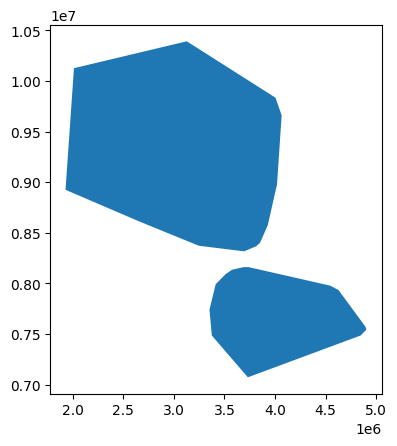

In [36]:
# see them
systems.convex_hull.plot()

Now, a GDF for the hulls:

In [37]:
systems_hulls=systems.convex_hull.to_frame()
systems_hulls['system']=['Amazon', 'Parana']
systems_hulls.rename(columns={0:'geometry'},inplace=True)
systems_hulls=systems_hulls.set_geometry('geometry')
systems_hulls.crs="EPSG:5641"
systems_hulls
#se convierte un hull en un GDF

geometry  system
0  POLYGON ((3695122.042 8316613.866, 3247949.959...  Amazon
1  POLYGON ((3732042.591 7071745.007, 3375860.780...  Parana

Next, the distance matrix:

In [38]:

distanceMatrixKM_sysHull_air=systems_hulls.set_index('system').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

distanceMatrixKM_sysHull_air

name    Deputado Luiz Eduardo Magalhães International Airport  \
system                                                          
Amazon                                        1555.314930       
Parana                                        1090.990829       

name    Eduardo Gomes International Airport  \
system                                        
Amazon                             0.000000   
Parana                          1600.729478   

name    Guarulhos - Governador André Franco Montoro International Airport  \
system                                                                      
Amazon                                        1306.312049                   
Parana                                          60.617335                   

name    Hercílio Luz International Airport  \
system                                       
Amazon                         1651.131292   
Parana                          467.481798   

name    Presidente Juscelino Kubitschek International Airport  \
system                                                          
Amazon                                         621.134831       
Parana                                         219.019018       

name    Rio Galeão – Tom Jobim International Airport  \
system                                                 
Amazon                                   1496.051553   
Parana                                    142.788995   

name    Tancredo Neves International Airport  \
system                                         
Amazon                           1208.584052   
Parana                            125.748586   

name    Val de Cans/Júlio Cezar Ribeiro International Airport  
system                                                         
Amazon                                          368.65893      
Parana                                         1789.43901

All the minimal differences:

In [39]:
mins=distanceMatrixKM_sysHull_air.idxmin(axis="columns")
mins
#distancias minimas

system
Amazon                  Eduardo Gomes International Airport
Parana    Guarulhos - Governador André Franco Montoro In...
dtype: object

In [40]:
# plotting
base=systems_hulls.explore()
largeAirports[largeAirports.name.isin(mins)].explore(m=base,color='red',marker_kwds=dict(radius=10))
largeAirports[~largeAirports.name.isin(mins)].explore(m=base,color='blue',marker_kwds=dict(radius=5))

### Exercise 3

<div class="alert-success">
    
1. Create a set of points and a set of polygons

2. Compute the distance matrix for both sets.

3. Select one polygon of the distance matrix, and plot the closests and the farthest point to that polygon.
    
</div>    

In [ ]:
#selecciona un poligono y coloca el punto mas lejano, no hay necesidad de hacer el mapa interactivo

## Distances using _Buffers_

A very important case in distance analysis is the use of buffers:

In [41]:
# remember:
distanceMatrixKM_riv_air

name                       Deputado Luiz Eduardo Magalhães International Airport  \
NAME                                                                               
Amazon                                                           1978.845762       
Araguaia                                                         1308.019242       
Guapore                                                          2458.024484       
Japura                                                           3117.822502       
Madeira                                                          2490.080873       
Madre de Dios                                                    2994.098026       
Orinoco                                                          3249.139817       
Paraguay                                                         1739.671168       
Parana                                                           1611.687580       
Purus                                                            2736.905571       
Putamayo                                                         3451.573354       
Rio Branco                                                       2903.473138       
Rio Grande, South America                                        1169.515892       
Rio Juruena                                                      2194.275300       
Rio Negro                                                        2619.414491       
Rio Paranaiba                                                    1091.253494       
Rio Teles Pires                                                  1823.107459       
San Francisco                                                     370.579153       
Tapajos                                                          2140.881144       
Tocantins                                                        1064.930616       
Xingu                                                            1557.130671       

name                       Eduardo Gomes International Airport  \
NAME                                                             
Amazon                                               25.427785   
Araguaia                                           1300.153160   
Guapore                                             982.524731   
Japura                                              503.372843   
Madeira                                             152.897925   
Madre de Dios                                       982.524731   
Orinoco                                             698.056740   
Paraguay                                           1600.729478   
Parana                                             2181.114140   
Purus                                               150.263432   
Putamayo                                            854.123150   
Rio Branco                                          263.496551   
Rio Grande, South America                          2179.073568   
Rio Juruena                                         526.221195   
Rio Negro                                             4.372137   
Rio Paranaiba                                      2078.248955   
Rio Teles Pires                                     526.221195   
San Francisco                                      2104.310283   
Tapajos                                             432.446561   
Tocantins                                          1176.263530   
Xingu                                               842.864305   

name                       Guarulhos - Governador André Franco Montoro International Airport  \
NAME                                                                                           
Amazon                                                           2548.243958                   
Araguaia                                                          960.812850                   
Guapore                                                          1984.059015                   
Japura                                                           307

In [42]:
# getting a value (it can be any value)
distanceMatrixKM_riv_air.loc['Amazon'].min()
#la distancia minima del amazonas a los demas es 25

25.427784752413228

We can use any value to create a buffer:

In [43]:
minMts=distanceMatrixKM_riv_air.loc['Amazon'].min()*1000

#the buffer is a polygon:
rivers[rivers.NAME=='Amazon'].buffer(distance = minMts)
#el buffer tiene un numero y se le debe dar por una razon

16    POLYGON ((2049168.257 9552457.429, 2049110.197...
dtype: geometry

In [44]:
# see buffer:
bufferAroundAmazon=rivers[rivers.NAME=='Amazon'].buffer(distance = minMts)
bufferAsBase=bufferAroundAmazon.explore(color='red')
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})

Above we used the buffer (red polygon), and the river (blue). Let me add a layer of airports (small ones):

In [45]:
small_airports=airports[airports['type']=='small_airport']

# plotting
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})
small_airports.explore(m=bufferAsBase,color='black')

Now, we can use the buffer (polygon) to keep the airports that are at that particular distance around the river:

In [46]:

riversWithinBuffer=small_airports.clip(mask=bufferAroundAmazon)
#
riversWithinBuffer

name           type  latitude_deg  \
501                   Almeirim Airport  small_airport     -1.479524   
3749                   Prainha Airport  small_airport     -1.784101   
3748                 Castanhal Airport  small_airport     -2.523611   
601         Alenquer Municipal Airport  small_airport     -1.917000   
1628                     Coari Airport  small_airport     -4.134060   
766                      Anori Airport  small_airport     -3.725643   
4343  Senadora Eunice Micheles Airport  small_airport     -3.469070   
4134      Santo Antônio do Içá Airport  small_airport     -3.084476   
2818                   Agrotec Airport  small_airport     -3.206820   
374                     Flores Airport  small_airport     -3.072917   
207                  Parintins Airport  small_airport     -2.673521   
507           Óbidos Municipal Airport  small_airport     -1.867981   
2682                    Juruti Airport  small_airport     -2.186667   
3290                 Oriximiná Airport  small_airport     -1.714080   
2451                Itapiranga Airport  small_airport     -2.736772   
4744                   Urucará Airport  small_airport     -2.528890   
2110                 Fonte Boa Airport  small_airport     -2.532610   

      longitude_deg  elevation_ft region_name           municipality  \
501      -52.578214         584.0        Pará               Almeirim   
3749     -53.489909         151.0        Pará                Prainha   
3748     -53.939720         502.0        Pará                Prainha   
601      -54.723100          55.0        Pará               Alenquer   
1628     -63.132599         131.0    Amazonas                  Coari   
766      -61.667054          82.0    Amazonas                  Anori   
4343     -68.921056         335.0    Amazonas  São Paulo De Olivença   
4134     -67.958457           NaN    Amazonas   Santo Antônio do Içá   
2818     -60.543010         105.0    Amazonas             Manacapuru   
374      -60.021937         203.0    Amazonas                 Manaus   
207      -56.777625          87.0    Amazonas              Parintins   
507      -55.514596         328.0        Pará                 Óbidos   
2682     -56.090279         108.0        Pará                 Juruti   
3290     -55.836201         262.0        Pará              Oriximiná   
2451     -58.026525           NaN    Amazonas             Itapiranga   
4744     -57.755798          98.0    Amazonas                Urucará   
2110     -66.083199         207.0    Amazonas              Fonte Boa   

                             geometry  
501   POINT (3934403.276 9836483.281)  
3749  POINT (3832975.264 9802811.400)  
3748  POINT (3782932.815 9721030.963)  
601   POINT (3695780.137 9788117.312)  
1628  POINT (2760205.448 9542753.694)  
766   POINT (2923250.453 9587994.673)  
4343  POINT (2116227.269 9616404.629)  
4134  POINT (2223318.459 9658975.711)  
2818  POINT (3048302.744 9645435.121)  
374   POINT (3106273.226 9660254.937)  
207   POINT (3467209.851 9704447.526)  
507   POINT (3607724.520 9793537.269)  
2682  POINT (3543678.559 9758297.719)  
3290  POINT (3571945.310 9810552.895)  
2451  POINT (3328267.064 9697449.922)  
4744  POINT (3358385.982 9720447.039)  
2110  POINT (2431944.959 9720035.540)

In [47]:
bufferAsBase=bufferAroundAmazon.explore(color='red')
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})
riversWithinBuffer.explore(m=bufferAsBase,color='black')
#aqui se crea la gtrafica de los aeropuertos que stan en la zona roja del buffer

In [48]:
# minimum of all the minimum by row
distanceMatrixKM_riv_air.min(axis=1).min() 

4.3721372006756996

In [49]:
# using the previous value
minMinMts_5=5*distanceMatrixKM_riv_air.min(axis=1).min()*1000


allMinBuffer=rivers.buffer(distance = minMinMts_5).explore(color='red')
rivers.explore(m=allMinBuffer,color='blue',style_kwds={'weight':0.5})
#aqui esta el buffer de todos los rios
#la medida tecnica es. (distance = minMinMts_5)

In [50]:
# you see all the buffer polygons:
riversAll_buf=rivers.buffer(distance = minMinMts_5)
riversAll_buf

0     POLYGON ((3709466.365 7075503.489, 3709295.228...
1     POLYGON ((4344507.305 7696919.321, 4343068.757...
2     POLYGON ((3738180.589 8138104.185, 3697510.330...
3     POLYGON ((4318607.737 7940722.486, 4351959.098...
4     POLYGON ((4689456.871 7736130.044, 4710198.428...
5     POLYGON ((3865864.973 8031547.986, 3865282.480...
6     POLYGON ((3677866.923 8415342.179, 3656146.037...
7     POLYGON ((4271451.760 8271545.074, 4270186.621...
8     POLYGON ((3801017.354 8384641.424, 3833989.866...
9     POLYGON ((3702653.615 9713175.052, 3690329.042...
10    POLYGON ((2560802.582 8840078.952, 2557767.051...
11    POLYGON ((3284396.979 9030761.538, 3284333.614...
12    POLYGON ((2529208.791 8876584.490, 2531066.343...
13    POLYGON ((2521111.915 8874711.220, 2519297.156...
14    POLYGON ((1971636.728 9007001.336, 1973047.303...
15    POLYGON ((2072890.967 9702659.244, 2128056.481...
16    POLYGON ((2052930.304 9550476.385, 2052787.439...
17    POLYGON ((2058152.818 9853227.169, 2056352

Now keep small airports in buffer:

In [51]:
allRiversWithinBuffs=small_airports.clip(riversAll_buf)
allRiversWithinBuffs

name           type  latitude_deg  \
4333        São Miguel do Iguaçu Airport  small_airport    -25.398889   
4099            Fazenda Paulista Airport  small_airport    -25.392105   
4100                     Tarobá Airstrip  small_airport    -25.548148   
338            Estância Hércules Airport  small_airport    -25.460699   
4098  Aeroclube de Foz do Iguaçu Airport  small_airport    -25.369710   
...                                  ...            ...           ...   
1171              Fazenda Murará Airport  small_airport      3.246090   
1172                Arroz Faccio Airport  small_airport      3.259257   
1127             Fazenda Paraíso Airport  small_airport      3.313599   
1170                      Bonfim Airport  small_airport      3.362100   
1165               Lago Grande I Airport  small_airport      3.442780   

      longitude_deg  elevation_ft region_name               municipality  \
4333     -54.234722         951.0      Paraná       São Miguel Do Iguaçu   
4099     -54.409799         820.0      Paraná  Santa Terezinha de Itaipu   
4100     -54.486641         735.0      Paraná  Santa Terezinha de Itaipu   
338      -54.598801         558.0      Paraná              Foz Do Iguaçu   
4098     -54.470508         840.0      Paraná  Santa Terezinha de Itaipu   
...             ...           ...         ...                        ...   
1171     -60.239986         381.0     Roraima                     Bonfim   
1172     -60.362473         272.0     Roraima                     Bonfim   
1127     -60.347130         200.0     Roraima                  Boa Vista   
1170     -59.823900         296.0     Roraima                     Bonfim   
1165     -60.352501         298.0     Roraima                     Bonfim   

                              geometry  
4333   POINT (3750113.206 7095260.791)  
4099   POINT (3730635.541 7096091.674)  
4100   POINT (3722086.705 7076967.727)  
338    POINT (3709608.704 7087688.173)  
4098   POINT (3723881.535 7098834.253)  
...                                ...  
1171  POINT (3082014.810 10358911.485)  
1172  POINT (3068387.870 10360368.915)  
1127  POINT (3070094.812 10366384.131)  
1170  POINT (3128305.265 10371753.079)  
1165  POINT (3069497.286 10380684.770)  

[548 rows x 8 columns]

<Axes: >

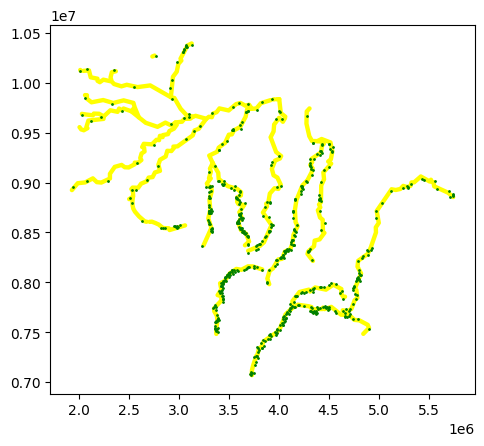

In [52]:
# simple; todos los areopuertos pequenos que caen en un buffer
base=riversAll_buf.plot(color='yellow')
allRiversWithinBuffs.plot(ax=base, color='green', markersize=1)

In [53]:
# folium

base=riversAll_buf.explore(color='yellow')
allRiversWithinBuffs.explore(m=base, color='green')

### Exercise 4

<div class="alert-success">
    
1. Create a set of points and a set of lines

2. Get the buffer for the lines, select different values for the distance.

3. Keep the points that are within the buffer (as in point 2, you need to play with differn distances until you show something interesting.  
    
</div>   

In [ ]:
#puntos y lineas hacer buffer a las lineas
#quedense con un clip que esta intersectando las lineas
#anotacion: se juega con los valores para intersectar el rio con el punto delñ aeropuerto, ademas se multiplica por 1000 para obtener el km

# Using data from spatial objects

This is time to use  *dataPeru_indicadores.xlsx* file and the  map of Peruvian districts: *DistritosMap.zip* (zipped shape file).

Let's read the data in :

In [55]:
# data table
import pandas as pd

peruData=os.path.join("data","dataPeru_indicadores.xlsx")
datadis=pd.read_excel(peruData,
                     dtype={'Ubigeo': object})
datadis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ubigeo                    1874 non-null   object 
 1   Departamento              1874 non-null   object 
 2   Provincia                 1874 non-null   object 
 3   Distrito                  1874 non-null   object 
 4   Poblacion                 1874 non-null   int64  
 5   Superficie                1874 non-null   float64
 6   IDH2019                   1874 non-null   float64
 7   Educ_sec_comp2019_pct     1874 non-null   float64
 8   NBI2017_pct               1874 non-null   float64
 9   Viv_sin_serv_hig2017_pct  1874 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 146.5+ KB


In [56]:
#se tiene la data y se tiene que hacer un merge para combinar las datas

In [57]:
# map
import geopandas as gpd

peruDataDist=os.path.join("maps","DistritosMap.zip")

datadismap=gpd.read_file(peruDataDist)

datadismap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DEPARTAMEN  1874 non-null   object  
 1   PROVINCIA   1874 non-null   object  
 2   DISTRITO    1874 non-null   object  
 3   INSTITUCIO  1874 non-null   object  
 4   geometry    1874 non-null   geometry
dtypes: geometry(1), object(4)
memory usage: 73.3+ KB


In [58]:
#siempre hagan un merge la data entra a la izquierda, busca donde poner la data, vean cuantas filas tiene. habian distritos que hay distritos repetidos

Next we will merge the indicators table into the map.

## Merging

When merging, verify the amount of resulting rows first:

In [59]:
datadismap.merge(datadis, left_on='DISTRITO', right_on='Distrito').shape

(2323, 15)

That is totally wrong. Let's check:

In [60]:
datadis.Distrito

0         ARAMANGO
1            BAGUA
2         COPALLIN
3         EL PARCO
4            IMAZA
           ...    
1869      CURIMANA
1870       IRAZOLA
1871       NESHUYA
1872    PADRE ABAD
1873         PURUS
Name: Distrito, Length: 1874, dtype: object

In [61]:
datadismap.DISTRITO

0       CORONEL GREGORIO ALBARRACIN LANCHIPA
1                                   POCOLLAY
2                                     CALANA
3                                      TACNA
4                                       SAMA
                        ...                 
1869                             CIENEGUILLA
1870                                   ANCON
1871                              CARABAYLLO
1872                                 MI PERU
1873                       SANTIAGO DE SURCO
Name: DISTRITO, Length: 1874, dtype: object

The amount of rows is the same when separate, but increases when merged. 

Let's do some preprocessing:

In [62]:
# all capitals, no empty spaces before or after.

capitalizeColumns=lambda x: x.str.upper().str.strip()
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].apply(capitalizeColumns)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].apply(capitalizeColumns)
#aqui se hace la limpieza para que no hayan distritos repetidos

The names from non-english speaking countries may come with some symbols that may cause trouble (', ~). Let's get rid of those:

In [64]:
import unidecode


byePunctuation=lambda x: unidecode.unidecode(x)
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].map(byePunctuation)  #applymap for olderpandas
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].map(byePunctuation) #applymap for olderpandas

Are the name of the districts unique?

In [65]:
datadis.Distrito.duplicated().sum(),datadismap.DISTRITO.duplicated().sum()

(154, 152)

The presence of duplicates, forces we create  a column of unique values:

In [66]:
# concatenating, se le coloca el mas para juntarlo para que no se repita
datadis['provDist']=["+".join(pd) for pd in zip (datadis.Provincia,datadis.Distrito)]
datadismap['provDist']=["+".join(pd) for pd in zip (datadismap.PROVINCIA,datadismap.DISTRITO)]

In [67]:
# the new column looks like this:
datadis['provDist'].head()

0    BAGUA+ARAMANGO
1       BAGUA+BAGUA
2    BAGUA+COPALLIN
3    BAGUA+EL PARCO
4       BAGUA+IMAZA
Name: provDist, dtype: object

It would be good making sure no *ghost* appears between words:

In [ ]:
#se crea lo anterior para hacer el merge luego se elimina

In [68]:
# replacing dashes and multiple spaces by a simple space
datadis['provDist']=datadis.provDist.str.replace("\-|\_|\s+"," ",regex=True)
datadismap['provDist']=datadismap.provDist.str.replace("\-|\_|\s+"," ",regex=True)

Let's find out what is NOT matched between the  tables:

In [69]:
nomatch_df=set(datadis.provDist)- set(datadismap.provDist)
nomatch_gdf=set(datadismap.provDist)-set(datadis.provDist) 

This is what could not be matched:

In [70]:
len(nomatch_df), len(nomatch_gdf)

(8, 8)

In [ ]:
#se tiene 8 distritos que no estan encajando, en siguiente lugar se vera cuales son para arreglarlo

Let's try renaming the districts using **fuzzy merging**:

In [72]:
# pick the closest match from nomatch_gdf for a value in nomatch_df
from thefuzz import process
[(dis,process.extractOne(dis,nomatch_gdf)) for dis in sorted(nomatch_df)]

[('ANGARAES+HUAYLLAY GRANDE', ('ANGARAES+HUALLAY GRANDE', 98)),
 ('AYMARAES+CARAYBAMBA', ('AYMARAES+CARAIBAMBA', 95)),
 ('AYMARAES+HUAYLLO', ('AYMARAES+IHUAYLLO', 97)),
 ('HUARAZ+PAMPAS', ('HUARAZ+PAMPAS GRANDE', 90)),
 ('LEONCIO PRADO+DANIEL ALOMIAS ROBLES',
  ('LEONCIO PRADO+DANIEL ALOMIA ROBLES', 99)),
 ('LIMA+PUEBLO LIBRE', ('LIMA+MAGDALENA VIEJA', 49)),
 ('PIURA+26 DE OCTUBRE', ('PIURA+VEINTISEIS DE OCTUBRE', 86)),
 ('SAN MARTIN+PAPAPLAYA', ('SAN MARTIN+PAPA PLAYA', 98))]

If you are comfortable, you prepare a _dictionary_ of changes:

In [73]:
# is this OK? #este es el diccionario
{dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

{'ANGARAES+HUAYLLAY GRANDE': 'ANGARAES+HUALLAY GRANDE',
 'AYMARAES+CARAYBAMBA': 'AYMARAES+CARAIBAMBA',
 'AYMARAES+HUAYLLO': 'AYMARAES+IHUAYLLO',
 'HUARAZ+PAMPAS': 'HUARAZ+PAMPAS GRANDE',
 'LEONCIO PRADO+DANIEL ALOMIAS ROBLES': 'LEONCIO PRADO+DANIEL ALOMIA ROBLES',
 'LIMA+PUEBLO LIBRE': 'LIMA+MAGDALENA VIEJA',
 'PIURA+26 DE OCTUBRE': 'PIURA+VEINTISEIS DE OCTUBRE',
 'SAN MARTIN+PAPAPLAYA': 'SAN MARTIN+PAPA PLAYA'}

In [74]:
# then: para cambiar
changesDis_df={dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

Now, make the replacements:

In [75]:
datadis.provDist.replace(changesDis_df,inplace=True)

Now the merge can happen:

In [77]:
datadisMap=datadismap.merge(datadis, on='provDist')
# check
datadisMap.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DEPARTAMEN                1874 non-null   object  
 1   PROVINCIA                 1874 non-null   object  
 2   DISTRITO                  1874 non-null   object  
 3   INSTITUCIO                1874 non-null   object  
 4   geometry                  1874 non-null   geometry
 5   provDist                  1874 non-null   object  
 6   Ubigeo                    1874 non-null   object  
 7   Departamento              1874 non-null   object  
 8   Provincia                 1874 non-null   object  
 9   Distrito                  1874 non-null   object  
 10  Poblacion                 1874 non-null   int64   
 11  Superficie                1874 non-null   float64 
 12  IDH2019                   1874 non-null   float64 
 13  Educ_sec_comp2019_pct     1874 non-null 

In [78]:
bye=['Departamento', 'Provincia', 'Distrito','INSTITUCIO','provDist']
datadisMap.drop(columns=bye,inplace=True)

# keeping
datadisMap.head()

DEPARTAMEN PROVINCIA                              DISTRITO  \
0      TACNA     TACNA  CORONEL GREGORIO ALBARRACIN LANCHIPA   
1      TACNA     TACNA                              POCOLLAY   
2      TACNA     TACNA                                CALANA   
3      TACNA     TACNA                                 TACNA   
4      TACNA     TACNA                                  SAMA   

                                            geometry  Ubigeo  Poblacion  \
0  POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...  230110     123662   
1  POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...  230108      22319   
2  POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...  230103       3338   
3  POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...  230101      80845   
4  POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...  230109       2679   

   Superficie   IDH2019  Educ_sec_comp2019_pct  NBI2017_pct  \
0      187.74  0.578968              71.178389         15.8   
1      265.65  0.645954              75.825743         16.1   
2      108.38  0.564102              77.829717         15.9   
3     1877.78  0.696613              75.491958          7.4   
4     1115.98  0.552622              70.500250         52.4   

   Viv_sin_serv_hig2017_pct  
0                       0.8  
1                       0.9  
2                       3.3  
3                       0.6  
4                      10.8

### Exercises Part II

<div class="alert-warning">
    
Exercises 5,6,7,8, and 9 for this part must read you data from GitHub links, and the coding and results must be published using GitHub Pages. This is a different project, so those exercises will be published in a different webpage.

</div>

### Exercise 5

<div class="alert-success">
    
1. Get a polygons map of the lowest administrative unit possible.
    
2. Get a table of variables for those units. At least 3 numerical variables.

3. Preprocess both tables and get them ready for merging.

4. Do the merging, making the changes needed so that you keep the most columns.
    
    
</div>

In [ ]:
#se puede usar provincias si no hay coudades
#se necesitan 3 variables numericas en excel, para hacer merge (variables muertos por covid, estadisticas
#poblacion y pobreza no interesa
#si cosas ambientales, economicas, a nivel de distritos o provincias, departamentos NO, puede ser cuantas personas tienen acceso a internet

## Exploring one variable

This time, we explore statistically one variable in the map:

In [79]:
# statistics
datadisMap.IDH2019.describe()

count    1874.000000
mean        0.409405
std         0.140059
min         0.091195
25%         0.304729
50%         0.386020
75%         0.507002
max         0.845217
Name: IDH2019, dtype: float64

In [81]:
!pip install seaborn 

   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.6 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 3.6 MB/s eta 0:00:00


<Axes: xlabel='IDH2019', ylabel='Count'>

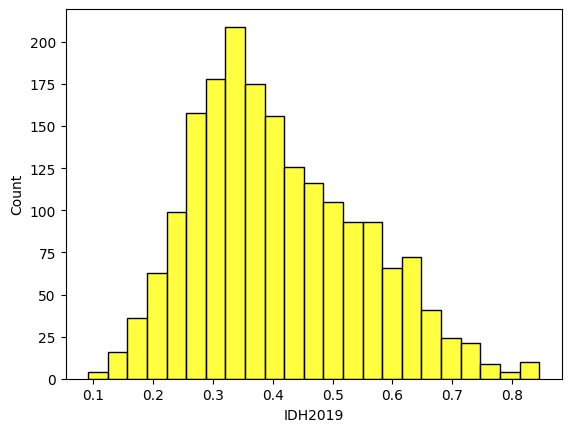

In [82]:
import seaborn as sea

sea.histplot(datadisMap.IDH2019, color='yellow')

In [84]:
!pip install numba

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
    --------------------------------------- 0.0/2.6 MB 991.0 kB/s eta 0:00:03
   -------- ------------------------------- 0.5/2.6 MB 6.8 MB/s eta 0:00:01
   ---------------- ----------------------- 1.1/2.6 MB 8.5 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.6 MB 9.0 MB/s eta 0:00:01
   ------------------------------ --------- 2.0/2.6 MB 9.0 MB/s eta 0:00:01
   ---------------------------------------  2.6/2.6 MB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 9.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
    --------------------------------------- 0.5/28.1 MB 15.2 MB/s eta 0:00:02
   - -------------------------------------- 1.0/28.1 MB 12.3 MB/s eta 0:00:03
   -- ------------------------------------- 1.6/28.1 MB 12.5 MB/s eta 0:00:03
   --- ------------------------------------ 2.3/28.1 MB 13.4 MB/s eta 0:00:02
   ---- -------

Notice the histogram divides the data in intervals which are the base of the bars. Seaborn uses the [Freedman-Diaconis](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) formula to compute the bins.

Let's see other possibilities, but please install [**numba**](https://numba.readthedocs.io/en/stable/user/installing.html) before runing the next code; also make sure you have **pysal**, **mapclassify** and **numpy** installed: 

In [86]:
import mapclassify 
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar=datadisMap['IDH2019']
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts                                
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data 
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)   

How can we select the right classification?

Let me use the the **absolute deviation around class median** (ADCM) to make the comparisson:

In [87]:
class5 = q5, ei5,msd, ht, mb5, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['Classifier'] = [c.name for c in class5]

# see the value
adcms

0      Classifier
0   55.367850       Quantiles
1   64.905426   EqualInterval
2  100.883593         StdMean
3   76.864415  HeadTailBreaks
4  206.210544   MaximumBreaks
5   54.577221     FisherJenks
6   53.506452    JenksCaspall
7   66.985129            MaxP

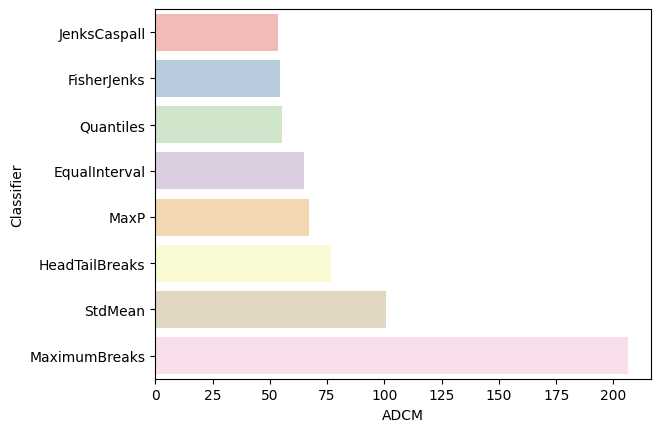

In [88]:
# rename
adcms.rename(columns = {0:'ADCM'},inplace=True)

# reorder and plot
adcms=adcms.sort_values('ADCM').reset_index()
sea.barplot(y='Classifier',
    hue='Classifier', x='ADCM', data=adcms, palette='Pastel1'
);

Let's keep the the scheme with the lowest  ADCM:

In [89]:
datadisMap['IDH_jc5'] = jc5.yb

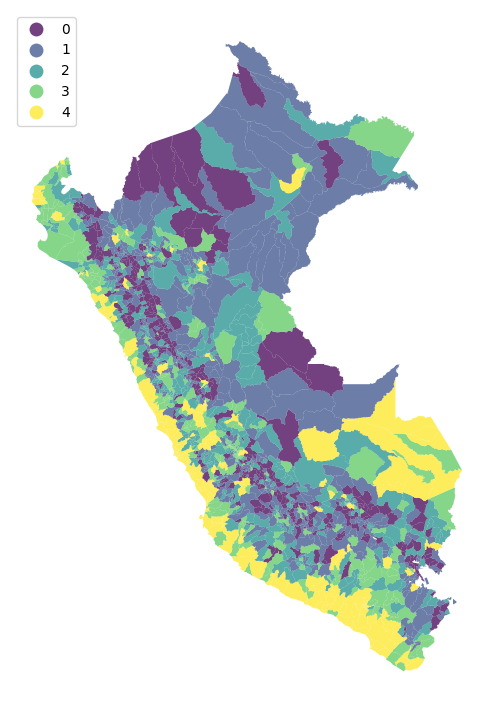

In [90]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(9, 9))
datadisMap.plot(column='IDH_jc5', 
        cmap='viridis', 
        categorical=True,
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

Notice the **geopandas.plot()** can also use those schemes:

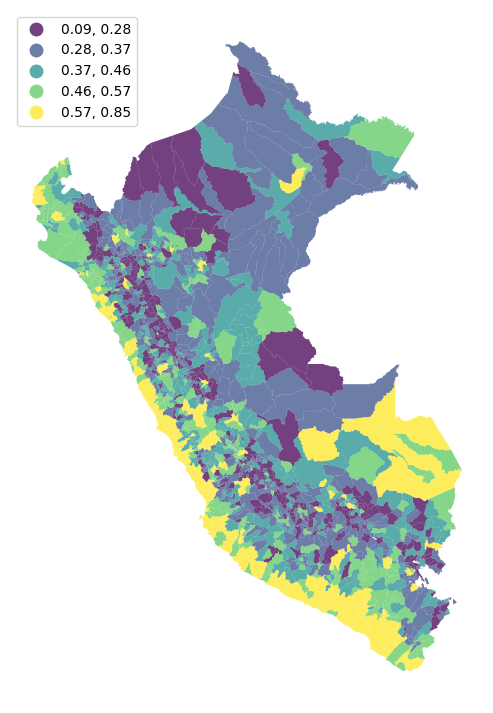

In [91]:
f, ax = plt.subplots(1, figsize=(9, 9))
datadisMap.plot(column='IDH2019', 
        cmap='viridis',       
        scheme='JenksCaspall',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

Notice some details on the result:

In [92]:
# we got
jc5

JenksCaspall

  Interval     Count
--------------------
[0.09, 0.28] |   352
(0.28, 0.37] |   484
(0.37, 0.46] |   403
(0.46, 0.57] |   351
(0.57, 0.85] |   284

In [93]:
# group label
np.unique(jc5.yb,return_counts=True)

(array([0, 1, 2, 3, 4]), array([352, 484, 403, 351, 284], dtype=int64))

In [94]:
# jc5.yb into a pandas Series

pd.Series(jc5.yb).value_counts()

1    484
2    403
0    352
3    351
4    284
Name: count, dtype: int64

In [95]:
# these are the cuts, but it is not including the min value
jc5.bins

array([0.28355126, 0.36657776, 0.45845445, 0.57085761, 0.84521661])

In [96]:
# completing the bins
jc5_bins=list(jc5.bins)
jc5_bins.insert(0,datadisMap.IDH2019.min())

<Axes: xlabel='IDH2019', ylabel='Count'>

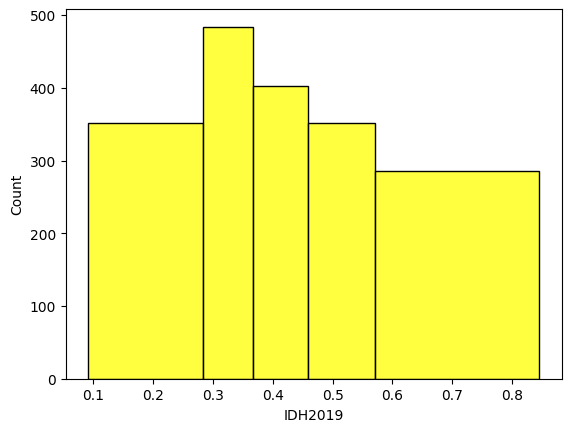

In [97]:
sea.histplot(datadisMap.IDH2019, bins=jc5_bins,color='yellow')

### Exercise 6

<div class="alert-success">
    
1. Choose a numeric variable from your merged data.
2. Decide which is the  best classification scheme for that variable.
3. Make a map for the best scheme.
4. Make a histogram for the best scheme.
</div>

In [98]:
#hacer mapa e histograma, te quedas con la mas chiquita y pides el esquema correcto
#pide hacer el histograma

## Neighborhood

We can compute the neighborhood for each object in a map using different algorithms:

In [100]:
!pip install libpysal

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB 1.3 MB/s eta 0:00:03
   ------ --------------------------------- 0.4/2.8 MB 5.5 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.8 MB 9.4 MB/s eta 0:00:01
   -------------------------- ------------- 1.9/2.8 MB 11.9 MB/s eta 0:00:01
   ----------------------------------- ---- 2.5/2.8 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 11.8 MB/s eta 0:00:00


In [101]:
from libpysal.weights import Queen, Rook, KNN
#se crean los 3 vecindarios

# rook
w_rook = Rook.from_dataframe(datadisMap,use_index=False) 

C:\Users\aml\.conda\envs\new\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 89, 122.
  warnings.warn(message)


In [102]:
# queen
w_queen = Queen.from_dataframe(datadisMap,use_index=False)

In [103]:
# k nearest neighbors son los vecinos mas cercanos solo le importa la cercania, el queen y el rock se diferencian en que el vecino rook es aquel que toca n una arista, en cambio el queen solo basta que toque un punto para convertirse en vecino
w_knn = KNN.from_dataframe(datadisMap, k=4)

Let's understand the differences:

In [104]:
# first district in the GDF:
datadisMap.head(1)

DEPARTAMEN PROVINCIA                              DISTRITO  \
0      TACNA     TACNA  CORONEL GREGORIO ALBARRACIN LANCHIPA   

                                            geometry  Ubigeo  Poblacion  \
0  POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...  230110     123662   

   Superficie   IDH2019  Educ_sec_comp2019_pct  NBI2017_pct  \
0      187.74  0.578968              71.178389         15.8   

   Viv_sin_serv_hig2017_pct  IDH_jc5  
0                       0.8        4

In [105]:
# amount of neighbors of that district
len(w_rook.neighbors[0])

1

In [106]:
# details
datadisMap.iloc[w_rook.neighbors[0],]

DEPARTAMEN PROVINCIA DISTRITO  \
3      TACNA     TACNA    TACNA   

                                            geometry  Ubigeo  Poblacion  \
3  POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...  230101      80845   

   Superficie   IDH2019  Educ_sec_comp2019_pct  NBI2017_pct  \
3     1877.78  0.696613              75.491958          7.4   

   Viv_sin_serv_hig2017_pct  IDH_jc5  
3                       0.6        4

<Axes: >

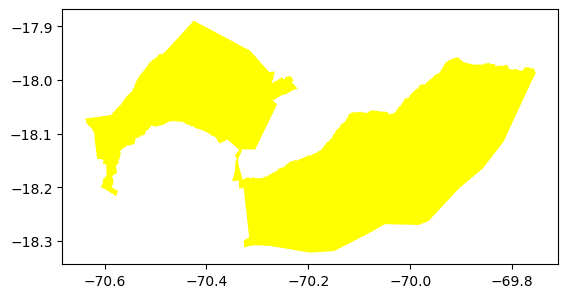

In [107]:
# see the neighbor
datadisMap.iloc[w_rook.neighbors[0] ,].plot(facecolor="yellow")

<Axes: >

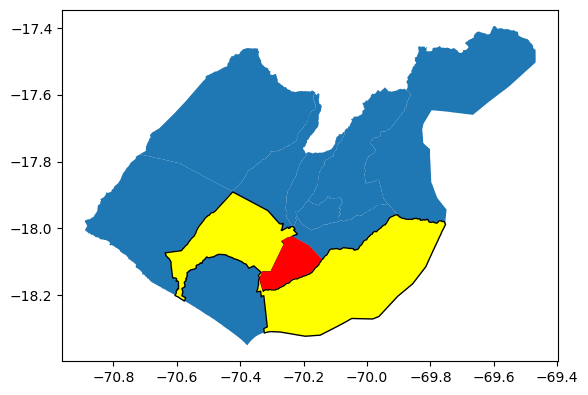

In [108]:
# see whole area
base=datadisMap[datadisMap.PROVINCIA=="TACNA"].plot()
datadisMap.iloc[w_rook.neighbors[0] ,].plot(ax=base,facecolor="yellow",edgecolor='k')
datadisMap.head(1).plot(ax=base,facecolor="red")

Let's do the same with queen neighbors:

In [109]:
# how many
len(w_queen.neighbors[0])

2

In [110]:
# details
datadisMap.iloc[w_queen.neighbors[0] ,]

DEPARTAMEN PROVINCIA  DISTRITO  \
1      TACNA     TACNA  POCOLLAY   
3      TACNA     TACNA     TACNA   

                                            geometry  Ubigeo  Poblacion  \
1  POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...  230108      22319   
3  POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...  230101      80845   

   Superficie   IDH2019  Educ_sec_comp2019_pct  NBI2017_pct  \
1      265.65  0.645954              75.825743         16.1   
3     1877.78  0.696613              75.491958          7.4   

   Viv_sin_serv_hig2017_pct  IDH_jc5  
1                       0.9        4  
3                       0.6        4

<Axes: >

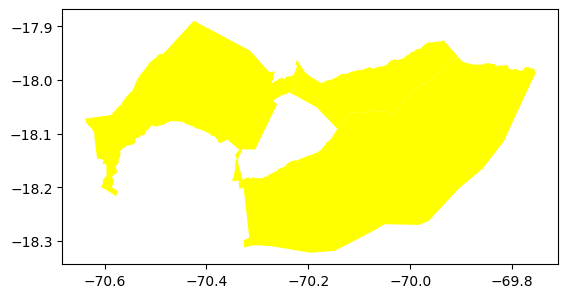

In [111]:
# see
datadisMap.iloc[w_queen.neighbors[0] ,].plot(facecolor="yellow")

<Axes: >

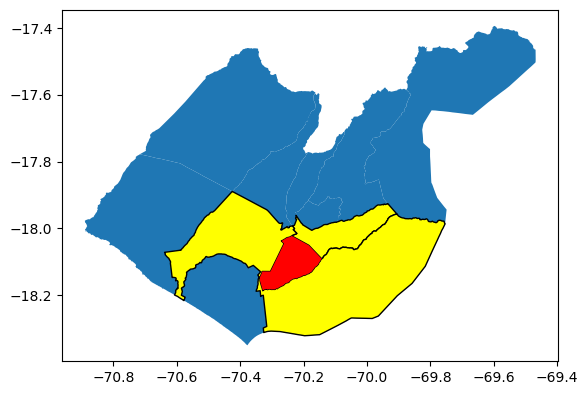

In [112]:
# whole area
base=datadisMap[datadisMap.PROVINCIA=="TACNA"].plot()
datadisMap.iloc[w_queen.neighbors[0] ,].plot(ax=base,facecolor="yellow",edgecolor='k')
datadisMap.head(1).plot(ax=base,facecolor="red")

In [113]:
w_knn.neighbors[0]

[3, 2, 1, 1806]

<Axes: >

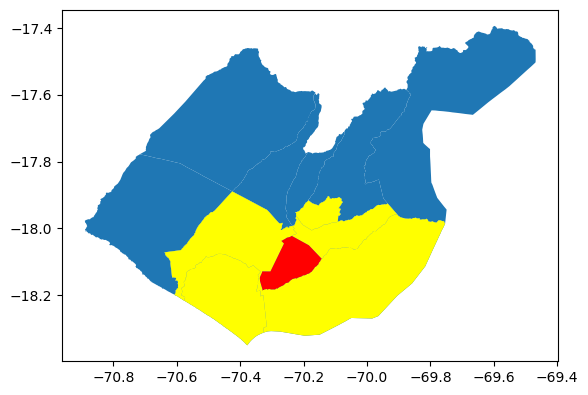

In [114]:
base=datadisMap[datadisMap.PROVINCIA=="TACNA"].plot()
datadisMap.iloc[w_knn.neighbors[0],].plot(ax=base,facecolor="yellow")
datadisMap.head(1).plot(ax=base,facecolor="red")

### Exercise 7

<div class="alert-success">
        
Compute the neighbors of the capital of your country. Plot the results for each of the options.
    
</div>

In [ ]:
#calcula los vecindarios de la capital en tu pais

## Spatial correlation

We need the neighboorhood matrix (the weight matrix) to compute spatial correlation: if the variable value is correlated with the values of its neighbors - which proves a spatial effect.

In [115]:
pd.DataFrame(*w_knn.full()) # 1 means both are neighbors

0     1     2     3     4     5     6     7     8     9     ...  1864  \
0      0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      1.0   0.0   1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   1.0   0.0   1.0   0.0   1.0   0.0   0.0   1.0   0.0  ...   0.0   
3      1.0   1.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1869   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1870   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1871   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1872   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1873   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      1865  1866  1867  1868  1869  1870  1871  1872  1873  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
1869   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1870   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0  
1871   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  
1872   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1873   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[1874 rows x 1874 columns]

In [116]:
# needed for spatial correlation
w_knn.transform = 'R'

In [120]:
pd.DataFrame(*w_knn.full()).head(12) # 1 means both are neighbors, aqui la suma me va a dar 1

0     1     2     3     4     5     6     7     8     9     ...  1864  \
0   0.00  0.25  0.25  0.25  0.00  0.00  0.00  0.00  0.00  0.00  ...   0.0   
1   0.25  0.00  0.25  0.25  0.00  0.25  0.00  0.00  0.00  0.00  ...   0.0   
2   0.00  0.25  0.00  0.25  0.00  0.25  0.00  0.00  0.25  0.00  ...   0.0   
3   0.25  0.25  0.25  0.00  0.00  0.25  0.00  0.00  0.00  0.00  ...   0.0   
4   0.00  0.00  0.00  0.00  0.00  0.00  0.25  0.00  0.00  0.00  ...   0.0   
5   0.00  0.25  0.25  0.00  0.00  0.00  0.00  0.00  0.25  0.25  ...   0.0   
6   0.00  0.00  0.00  0.00  0.25  0.00  0.00  0.25  0.00  0.00  ...   0.0   
7   0.00  0.00  0.00  0.00  0.00  0.00  0.25  0.00  0.00  0.00  ...   0.0   
8   0.00  0.00  0.25  0.00  0.00  0.25  0.00  0.00  0.00  0.25  ...   0.0   
9   0.00  0.00  0.25  0.00  0.00  0.25  0.00  0.00  0.00  0.00  ...   0.0   
10  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.25  ...   0.0   
11  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.25  ...   0.0   

    1865  1866  1867  1868  1869  1870  1871  1872  1873  
0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
8    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
10   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
11   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[12 rows x 1874 columns]

In [119]:
!pip install esda

   ---------------------------------------- 0.0/132.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/132.4 kB ? eta -:--:--
   --------------------------- ------------ 92.2/132.4 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 132.4/132.4 kB 2.0 MB/s eta 0:00:00


Spatial correlation is measured by the Moran's I statistic:

In [121]:
from esda.moran import Moran

moranIDH = Moran(datadisMap['IDH2019'], w_knn)
moranIDH.I,moranIDH.p_sim
#dame la data, te pide la matriz de vecindarios para hacer el calculo, te entrega el indice de moran y su significancia 0.68 - 0.01, existe correclacion espacial.
#lo que calcula es la ubicacion de los valores esta tendiendo a crear vecindarios. ejemplo, los lugares que tienen poco desarrollo huma estan cerca a lugares que tiennen poco desarrollo humano

(0.6837588552721255, 0.001)

A significant Moran's I suggest spatial correlation. Let's see the spatial scatter plot

In [123]:
!pip install splot

     ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
     ---------------------------------------- 61.1/61.1 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     --- ------------------------------------ 0.5/5.7 MB 11.1 MB/s eta 0:00:01
     ------- -------------------------------- 1.1/5.7 MB 11.4 MB/s eta 0:00:01
     ------------ --------------------------- 1.8/5.7 MB 12.8 MB/s eta 0:00:01
     ------------------ --------------------- 2.7/5.7 MB 14.3 MB/s eta 0:00:01
     ---------------------- ----------------- 3.2/5.7 MB 13.6 MB/s eta 0:00:01
     ---------------------------- ----------- 4.1/5.7 MB 14.5 MB/s eta 0:00:01
     ---------------------------------- ----- 4.9/5.7 MB 15.0 MB/s eta 0:00:01
     ------------------------------------- -- 5.4/5.7 MB 14.9 MB/s eta 0:00:01
     ---------------------------------------- 5.7/5.7 MB 14.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/536.2 kB ? eta -

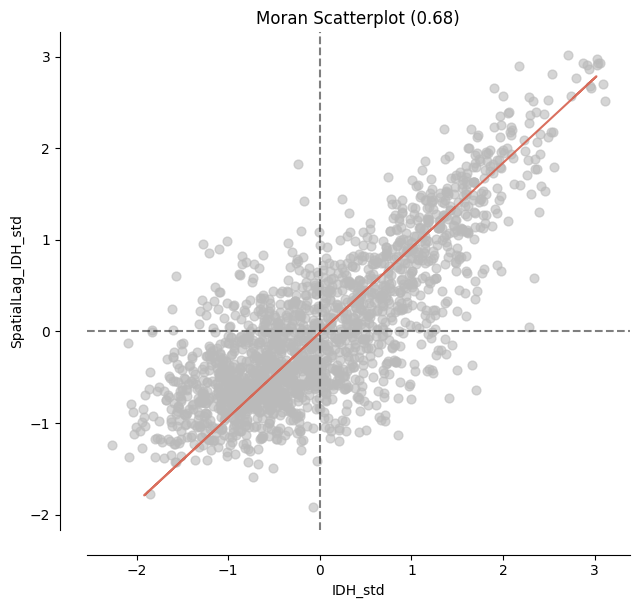

In [124]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moranIDH, aspect_equal=True)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std');

In [ ]:
#la correlacion es positiva es creciente

### Exercise 8

<div class="alert-success">
    
1. Compute the Moran's coefficient for **all** your numeric variables.
    
2. Make a scatter plot for each variable.
    
</div>

In [ ]:
#si tienes 3 variables tienes que calcular los 3 indices de moran

### Local Spatial Correlation

We can compute a LISA (local Moran) for each case. That will help us find spatial clusters (spots) and spatial outliers:

* A **hotSpot** is a polygon whose value in the variable is high AND is surrounded with polygons with also high values.

* A **coldSpot** is a polygon whose value in the variable is low AND is surrounded with polygons with also low values.

* A **coldOutlier** is a polygon whose value in the variable is low BUT is surrounded with polygons with  high values.

* A **hotOutlier** is a polygon whose value in the variable is high BUT is surrounded with polygons with  low values.

It is also possible that no significant correlation is detected. Let's see those values:

In [ ]:
#coldOutlier  es un distrito que tiene valores bajos pero esta rodeado de altos

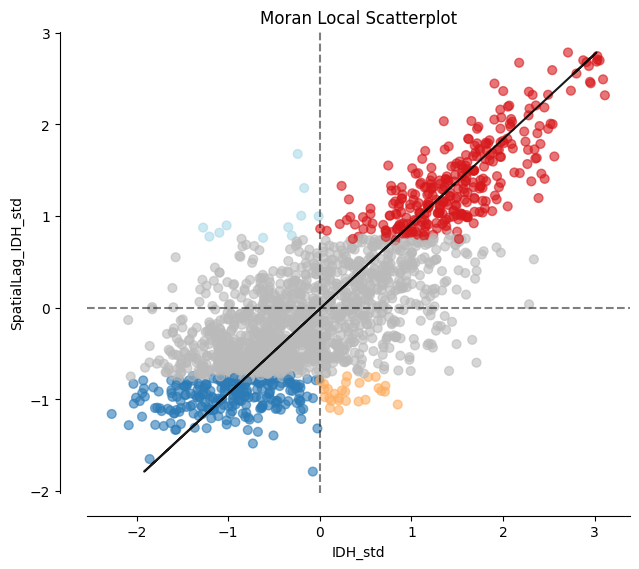

In [125]:
# The scatterplot with local info
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisaIDH = Moran_Local(y=datadisMap['IDH2019'], w=w_knn,seed=2022)
fig, ax = moran_scatterplot(lisaIDH,p=0.05)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std');
#plt.show()

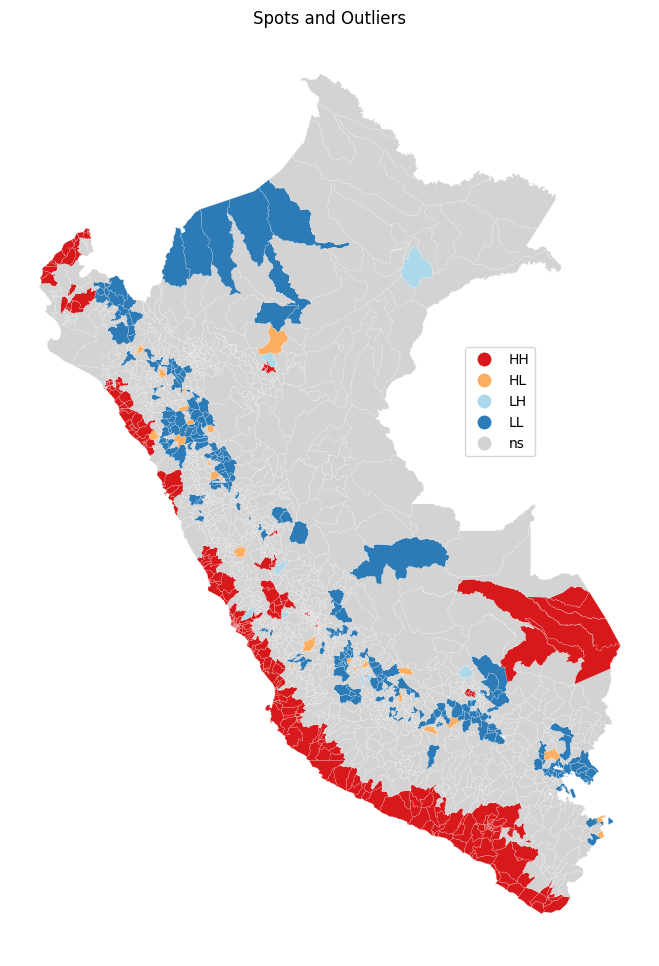

In [126]:
# the map with the spots and outliers
import matplotlib.pyplot as plt

from splot.esda import lisa_cluster
f, ax = plt.subplots(1, figsize=(12, 12))
plt.title('Spots and Outliers')
fig = lisa_cluster(lisaIDH, 
                   datadisMap,ax=ax,
                   legend_kwds={'loc': 'center left', 
                                'bbox_to_anchor': (0.7, 0.6)});
plt.show()

In [ ]:
#es el mapa del peru con distritos
#rojo que estan bien pero cerca a los que estan mal en IDH
#naranja atipicos calientes

Let me add that data to my gdf:

In [127]:
# quadrant
lisaIDH.q

array([1, 1, 1, ..., 1, 1, 1])

In [128]:
# significance
lisaIDH.p_sim

array([0.005, 0.011, 0.005, ..., 0.002, 0.002, 0.001])

In [129]:
# quadrant: 1 HH,  2 LH,  3 LL,  4 HL
pd.Series(lisaIDH.q).value_counts()

3    873
1    618
4    209
2    174
Name: count, dtype: int64

The info in **lisaIDH.q** can not be used right away, we need to add if the local spatial correlation is significant:

In [130]:
datadisMap['IDH_quadrant']=[l if p <0.05 else 0 for l,p in zip(lisaIDH.q,lisaIDH.p_sim)  ]
datadisMap['IDH_quadrant'].value_counts()

IDH_quadrant
0    1283
1     308
3     245
4      27
2      11
Name: count, dtype: int64

Now, we recode:

In [131]:
labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']

datadisMap['IDH_quadrant_names']=[labels[i] for i in datadisMap['IDH_quadrant']]

datadisMap['IDH_quadrant_names'].value_counts()

IDH_quadrant_names
0 no_sig         1283
1 hotSpot         308
3 coldSpot        245
4 hotOutlier       27
2 coldOutlier      11
Name: count, dtype: int64

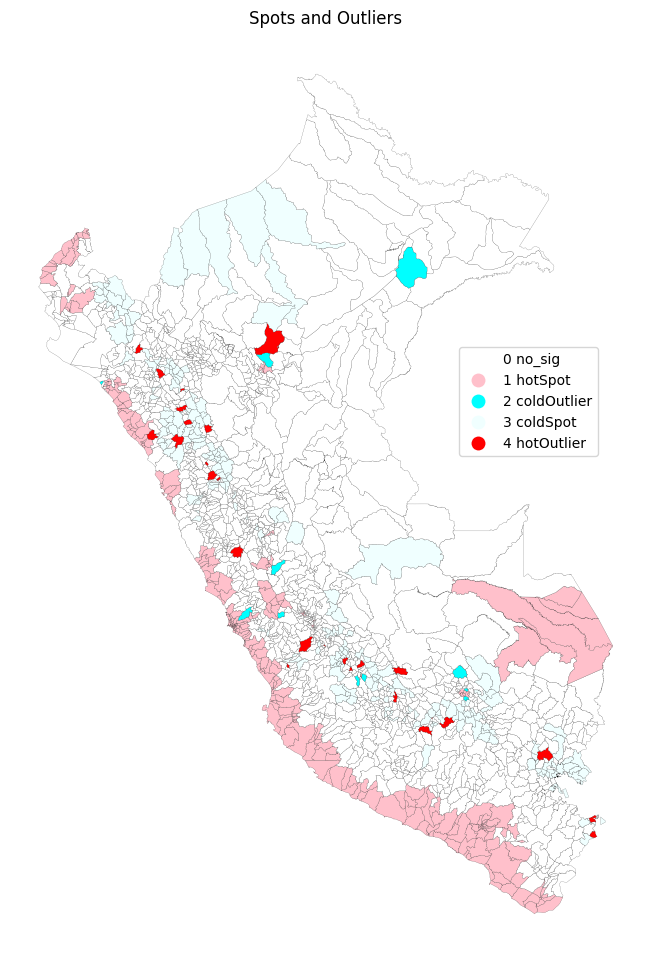

In [132]:
from matplotlib import colors
myColMap = colors.ListedColormap([ 'white', 'pink', 'cyan', 'azure','red'])



# Set up figure and ax
f, ax = plt.subplots(1, figsize=(12,12))
# Plot unique values choropleth including
# a legend and with no boundary lines

plt.title('Spots and Outliers')

datadisMap.plot(column='IDH_quadrant_names', 
                categorical=True,
                cmap=myColMap,
                linewidth=0.1, 
                edgecolor='k',
                legend=True,
                legend_kwds={'loc': 'center left', 
                             'bbox_to_anchor': (0.7, 0.6)},
                ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [ ]:
#cero no hay significancia espacial

### Exercise 9

<div class="alert-success">
    
1. Compute the Local Moran for the variables in your data that have significant spatial correlation.
    
2. Create a new column for each of those variables, with a label ('0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier').

3. Prepare a map for each of the variables analyzed, showing the spots and outliers.
    
</div>

In [ ]:
#se juega con las matrices y los calculos seran en knn
#crea el mapa final, crear 3 mapas ya que tenemos 3 variables analizadas